# 02 — First Model: CNN + BiLSTM + CTC
Status: **Overfit / failed to generalize**. Kept to document the path and justify later choices.


# Prepare Environment

## 1. Mount Drive
Mount Google Drive (only needed in Colab).



In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')


## 2. Import packages
Load all Python libraries used later.




In [ ]:
# Basic imports
import os
import torch
import torchaudio
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import librosa
from tqdm import tqdm

from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence


## 3. Set paths
Define project root and subfolders (change `ROOT` to your clone path).

In [ ]:
# Cell — Config paths (Notebook 2: model training)
import os, sys
from pathlib import Path

# detect if running in Colab
IN_COLAB = "google.colab" in sys.modules

# CONFIG: project root folder
# Change this path to the folder where you cloned/downloaded the repo
ROOT = Path("/content/drive/MyDrive/GitHub/musdb18-asr-dl") if IN_COLAB else Path.cwd()

# canonical subfolders
DATA_RAW        = ROOT / "data" / "raw"
DATA_PROCESSED  = ROOT / "data" / "processed"
OUT_DIR         = ROOT / "outputs"
CHECKPOINTS_DIR = ROOT / "checkpoints"
LOGS_DIR        = ROOT / "logs"

# Hugging Face cache (persistent if on Colab + Drive)
HF_CACHE = Path(
    os.environ.get(
        "HF_CACHE",
        "/content/drive/MyDrive/hf_cache" if IN_COLAB else (Path.home() / ".cache" / "huggingface")
    )
)
os.environ["HF_HOME"] = str(HF_CACHE)
os.environ["HF_DATASETS_CACHE"] = str(HF_CACHE)
os.environ["TRANSFORMERS_CACHE"] = str(HF_CACHE)

# ensure dirs exist
for d in [DATA_RAW, DATA_PROCESSED, OUT_DIR, CHECKPOINTS_DIR, LOGS_DIR, HF_CACHE]:
    d.mkdir(parents=True, exist_ok=True)

# quick printout
print("ROOT         :", ROOT)
print("DATA_RAW     :", DATA_RAW)
print("DATA_PROCESSED:", DATA_PROCESSED)
print("OUT_DIR      :", OUT_DIR)
print("CHECKPOINTS  :", CHECKPOINTS_DIR)
print("LOGS_DIR     :", LOGS_DIR)
print("HF_CACHE     :", HF_CACHE)


# Data Process

## Extract Audio Features (Mel Spectrograms) From vocal-only stem
convert each vocal stem audio chunk into a log-Mel spectrogram.

In [ ]:
# Parameters
SR = 16000  # Sampling rate
N_MELS = 80
HOP_LENGTH = 320
WIN_LENGTH = 1024

# Paths
CHUNKS_DIR = DATA_PROCESSED / "train_chunks" / "vocals"
CSV_PATH = DATA_PROCESSED / "train_segments_chunked.csv"
FEATURES_DIR = DATA_PROCESSED / "features_vocals"



# Load segment metadata
df = pd.read_csv(CSV_PATH)
df = df[df['has_lyrics'] == True].reset_index(drop=True)  # keep only vocal chunks with actual lyrics and resets the index

# Create output folder
os.makedirs(FEATURES_DIR, exist_ok=True)

# Process each chunk
for idx, row in tqdm(df.iterrows(), total=len(df)):
    audio_path = row['chunk_path']
    try:
        # Load audio
        y, _ = librosa.load(audio_path, sr=SR, mono=True)

        # Compute log-mel spectrogram
        mel = librosa.feature.melspectrogram(y=y, sr=SR, n_fft=WIN_LENGTH,
                                             hop_length=HOP_LENGTH,
                                             n_mels=N_MELS)
        log_mel = librosa.power_to_db(mel, ref=np.max)

        # Save as tensor
        tensor = torch.tensor(log_mel).float()
        out_path = os.path.join(FEATURES_DIR, f"{idx}.pt")
        torch.save(tensor, out_path)
    except Exception as e:
        print(f"Error processing {audio_path}: {e}")


## Prepare Text Labels (Character-Level)
tokenize lyrics into characters and save them aligned to the audio features.

In [ ]:
import os
import json
import torch
import pandas as pd
from tqdm import tqdm

# Paths
CSV_PATH = DATA_PROCESSED / "train_segments_chunked.csv"
LABELS_DIR = DATA_PROCESSED / "labels_vocals"

# Load lyric segment metadata
df = pd.read_csv(CSV_PATH)
df = df[df['has_lyrics'] == True].reset_index(drop=True)  # keep only vocal chunks with actual lyrics, and resets the index

# Build character-level vocabulary from all non-empty lyrics
valid_lyrics = df[df['has_lyrics']]['Lyric'].dropna().str.lower().unique()
vocab = sorted(set(''.join(valid_lyrics)))

# Map: character → index (0 is reserved for padding)
char2idx = {c: i + 1 for i, c in enumerate(vocab)}
char2idx['<pad>'] = 0
idx2char = {i: c for c, i in char2idx.items()}

# Save vocab (character → index mapping)
VOCAB_DIR = DATA_PROCESSED / "vocab"
VOCAB_DIR.mkdir(parents=True, exist_ok=True)

VOCAB_PATH = VOCAB_DIR / "char2idx_vocals.json"
with open(VOCAB_PATH, "w") as f:
    json.dump(char2idx, f)

# Create output directory
os.makedirs(LABELS_DIR, exist_ok=True)

# Generate and save label tensors
for idx, row in tqdm(df.iterrows(), total=len(df)):
    lyric = row['Lyric'].lower().strip() if row['has_lyrics'] else ''
    label_tensor = torch.tensor([char2idx[c] for c in lyric if c in char2idx], dtype=torch.long)
    torch.save(label_tensor, os.path.join(LABELS_DIR, f'{idx}.pt'))


100%|██████████| 1940/1940 [00:09<00:00, 199.83it/s]


## Sanity check on feature and label tensors

Load and inspect a sample feature and its corresponding label to confirm correct formatting, shape, and character mapping.


In [ ]:
import torch
import json

# Sample index to inspect
sample_idx = 420

# Load feature
feature_path = FEATURES_DIR / f"{sample_idx}.pt"
feature = torch.load(feature_path)
print("Feature shape:", feature.shape)
print("Feature dtype:", feature.dtype)
print("Feature stats — min:", feature.min().item(), "max:", feature.max().item())

# Load label
label_path = LABELS_DIR / f"{sample_idx}.pt"
label = torch.load(label_path)
print("Label indices:", label.tolist())

# Load vocab
VOCAB_PATH = (DATA_PROCESSED / "vocab" / "char2idx_vocals.json")
with open(VOCAB_PATH, "r") as f:
    char2idx = json.load(f)
idx2char = {int(i): c for c, i in char2idx.items()}

# Decode label
decoded = "".join([idx2char[i] for i in label.tolist()])
print("Decoded lyric:", decoded)


Feature shape: torch.Size([80, 301])
Feature dtype: torch.float32
Feature stats — min: -72.22659301757812 max: 0.0
Label indices: [19, 23, 11, 5, 13, 14, 27, 1, 3, 8, 22, 7, 20, 1, 27, 17, 23]
Decoded lyric: quickly after you


# Model Setup

## Define PyTorch Dataset
create a custom dataset class that loads the log-mel and the label tensors by index

In [ ]:
from torch.utils.data import Dataset, DataLoader

class LyricDatasetVocalOnly(Dataset):
    def __init__(self, index_list, features_dir, labels_dir):
        self.index_list = index_list
        self.features_dir = features_dir
        self.labels_dir = labels_dir

    def __len__(self):
        return len(self.index_list)

    def __getitem__(self, idx):
        i = self.index_list[idx]
        x = torch.load(os.path.join(self.features_dir, f"{i}.pt"))
        y = torch.load(os.path.join(self.labels_dir, f"{i}.pt"))
        return x, y


## Define collate function for batching variable-length samples

Function that pads the feature and label sequences within each batch and returns the original lengths required for CTC loss. It enables batch training on variable-length audio and transcription sequences.


In [ ]:
def collate_fn(batch):
    """
    Pads a batch of (feature, label) pairs for CTC training.
    Returns:
        padded_features: Tensor [B, 1, 80, T_max]
        padded_labels:   Tensor [B, L_max]
        input_lengths:   Tensor [B] - original T for each input
        label_lengths:   Tensor [B] - original length of each label
    """
    features, labels = zip(*batch)

    # Feature padding (pad along time dimension)
    feature_lengths = torch.tensor([f.shape[1] for f in features], dtype=torch.long)
    padded_features = torch.nn.utils.rnn.pad_sequence(
        [f.T for f in features],  # transpose to [T, 80] for padding
        batch_first=True
    ).permute(0, 2, 1).unsqueeze(1)  # [B, 1, 80, T_max]

    # Label padding
    label_lengths = torch.tensor([len(l) for l in labels], dtype=torch.long)
    padded_labels = torch.nn.utils.rnn.pad_sequence(
        labels,
        batch_first=True,
        padding_value=0  # index 0 is <pad>
    )

    return padded_features, padded_labels, feature_lengths, label_lengths


## Define train_dataset

In [ ]:
import os

# Set paths
feature_dir = DATA_PROCESSED / "features_vocals"
label_dir = DATA_PROCESSED / "labels_vocals"

# Index list — all available samples
num_samples = len(os.listdir(feature_dir))  # assumes 0.pt, 1.pt, ...
index_list = list(range(num_samples))

# Create the dataset
train_dataset = LyricDatasetVocalOnly(index_list, feature_dir, label_dir)


### Dta_set Sanity check

In [ ]:
import torch

print("train dataset length:",len(train_dataset))

feature, label = train_dataset[42]  # can be any index...

print("Feature shape:", feature.shape)   # should be [80, T]
print("Feature dtype:", feature.dtype)

print("Label indices:", label.tolist())  # should be list of ints
print("Label length:", len(label))


train dataset length: 1940
Feature shape: torch.Size([80, 451])
Feature dtype: torch.float32
Label indices: [5, 17, 15, 7, 1, 3, 16, 6, 1, 5, 17, 15, 7]
Label length: 13


In [ ]:
import json

# Path to vocab JSON
VOCAB_PATH = DATA_PROCESSED / "vocab" / "char2idx_vocals.json"

# Load vocab
with open(VOCAB_PATH, "r") as f:
    char2idx = json.load(f)

# Build reverse mapping: index → character
idx2char = {int(i): c for c, i in char2idx.items()}

# Decode the label tensor into text
decoded = "".join(idx2char[i] for i in label.tolist())
print("Decoded lyric:", decoded)


Decoded lyric: quickly after you


## Create DataLoader for training

Instantiate a PyTorch DataLoader with batching, shuffling, and the custom collate function.


In [ ]:
from torch.utils.data import DataLoader

# Create DataLoader
train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=16,  # adjust based on memory
    shuffle=True,
    collate_fn=collate_fn
)


## Define the CNN+CTC Baseline Model — Feature Extractor

First component of the model: a simple convolutional feature extractor. It applies 2D convolutional layers over the padded log-Mel spectrograms to extract time-frequency features. The output is reshaped and passed to a linear layer for character classification. This version uses basic conv → ReLU → dropout → batch norm layers.


In [ ]:
import torch.nn as nn

class CNNCTCModel(nn.Module):
    def __init__(self, vocab_size):
        super(CNNCTCModel, self).__init__()

        self.cnn = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),  # [B, 1, 80, T] -> [B, 32, 80, T]
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Dropout(0.1),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),  # [B, 32, 80, T] -> [B, 64, 80, T]
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(0.1)
        )

        # Final linear projection to vocab logits per time step
        self.classifier = nn.Linear(64 * 80, vocab_size)  # 64 channels × 80 freq bins

    def forward(self, x):
        # Input: x shape = [B, 1, 80, T]
        x = self.cnn(x)  # still [B, 64, 80, T]

        # Collapse freq dimension
        x = x.permute(0, 3, 1, 2)  # [B, T, 64, 80]
        x = x.reshape(x.shape[0], x.shape[1], -1)  # [B, T, 5120]

        # Project to vocab logits
        logits = self.classifier(x)  # [B, T, vocab_size]
        return logits


## Instantiate model and define CTC loss

creates an instance of the CNN+CTC model and sets up the CTC loss function. CTC (Connectionist Temporal Classification) allows the model to learn alignment between the predicted character sequence and the ground-truth lyrics without requiring exact timing.


In [ ]:
import torch
import torch.nn as nn

# Path to vocab JSON
VOCAB_PATH = DATA_PROCESSED / "vocab" / "char2idx_vocals.json"

# Load vocab
with open(VOCAB_PATH, "r") as f:
    char2idx = json.load(f)

vocab_size = len(char2idx)

# Instantiate model
model = CNNCTCModel(vocab_size=vocab_size)

# Move to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Define CTC loss function
ctc_loss = nn.CTCLoss(blank=0, zero_infinity=True)  # 0 = padding index


# Train

## Define optimizer and training loop

Set up the optimizer and training loop to perform forward passes, compute CTC loss, backpropagate gradients, and update model weights. it also log training loss for monitoring.


In [ ]:
from torch.optim import Adam

# Optimizer
optimizer = Adam(model.parameters(), lr=1e-4)

# Training loop setup
num_epochs = 25
print_every = 30  # print loss every N batches

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for batch_idx, (features, labels, input_lengths, label_lengths) in enumerate(train_loader):
        features = features.to(device)
        labels = labels.to(device)
        input_lengths = input_lengths.to(device)
        label_lengths = label_lengths.to(device)

        # Forward pass
        logits = model(features)  # [B, T, vocab_size]
        logits = logits.permute(1, 0, 2)  # for CTC: [T, B, vocab_size]

        # Compute loss
        loss = ctc_loss(logits, labels, input_lengths, label_lengths)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Logging
        if (batch_idx + 1) % print_every == 0:
            avg_loss = running_loss / print_every
            print(f"Epoch {epoch+1}, Batch {batch_idx+1}, Loss: {avg_loss:.4f}")
            running_loss = 0.0


## Visual inspection of model predictions

decodes a few predictions from the trained model using argmax decoding (greedy) and compares them to the ground-truth lyrics to evaluate alignment quality.


In [ ]:
import torch.nn.functional as F

# Path to vocab JSON
VOCAB_PATH = DATA_PROCESSED / "vocab" / "char2idx_vocals.json"

# Load vocab
with open(VOCAB_PATH, "r") as f:
    char2idx = json.load(f)

# Reverse mapping: index → character
idx2char = {int(i): c for c, i in char2idx.items()}

def decode_argmax(predictions):
    """
    Takes [T, B, vocab_size] predictions and returns a list of decoded strings
    """
    pred_indices = predictions.argmax(dim=-1).cpu().numpy()  # [T, B]
    decoded_batch = []

    for b in range(pred_indices.shape[1]):
        pred = pred_indices[:, b]
        prev_char = None
        decoded = []
        for idx in pred:
            if idx != prev_char and idx != 0:  # skip blanks and repeats
                decoded.append(idx2char.get(int(idx), '?'))
            prev_char = idx
        decoded_batch.append(''.join(decoded))

    return decoded_batch

# Pick a few batches to inspect
model.eval()
with torch.no_grad():
    for batch_idx, (features, labels, input_lengths, label_lengths) in enumerate(train_loader):
        features = features.to(device)
        labels = labels.to(device)

        logits = model(features)  # [B, T, vocab_size]
        logits = logits.permute(1, 0, 2)  # [T, B, vocab_size]

        predictions = decode_argmax(logits)

        for i in range(len(predictions)):
            label_text = ''.join([idx2char[int(idx)] for idx in labels[i].cpu().tolist() if idx != 0])
            print(f"🔊 PRED: {predictions[i]}")
            print(f"✅ TRUE: {label_text}")
            print("-" * 50)

        break  # just look at one batch


🔊 PRED: uh h h h h h h h h h h h h h h h h h h h
✅ TRUE: the wind blew my name through the trees the sun painted portraits of me in the sky
--------------------------------------------------
🔊 PRED: ah h h h h h h h h h h h h h h h h h h h h h h h  h
✅ TRUE: so take your twelve strings to the antic shop let somebody please please stop the rock
--------------------------------------------------
🔊 PRED: h h h h h h h h h h h h h h h h h h h hh h
✅ TRUE: i don't know when i will drop the needle on you again no
--------------------------------------------------
🔊 PRED: h h h h h hh h
✅ TRUE: uh the devil's words has spoken to me
--------------------------------------------------
🔊 PRED: uh h hh h
✅ TRUE: take us apart
--------------------------------------------------
🔊 PRED: ah h h h h h hh h
✅ TRUE: oh yeah baby inside on me yeah
--------------------------------------------------
🔊 PRED: uh h  h h h h h h h h h  h h h h h h h h h h h h h h h h h h h h hh
✅ TRUE: ah welcome to the gates o

# Enhanced Model Setup

## Define an enhanced CNN + BiLSTM + CTC model

This version adds a bidirectional LSTM after the CNN layers. The CNN acts as a feature extractor, and the BiLSTM enables temporal modeling across time steps, helping the model align audio patterns with characters in context.


In [ ]:
import torch.nn as nn

class CNNBiLSTMCTCModel(nn.Module):
    def __init__(self, vocab_size):
        super().__init__()

        # CNN feature extractor: learns local time-frequency patterns
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),  # input: [B, 1, 80, T] → output: [B, 32, 80, T]
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Dropout(0.1),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),  # output: [B, 64, 80, T]
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(0.1)
        )

        # Define dimensions for the LSTM input
        self.lstm_input_dim = 64 * 80  # flatten [64 channels × 80 freq bins]
        self.lstm_hidden_dim = 256     # LSTM hidden size

        # BiLSTM to learn temporal structure (left-to-right + right-to-left)
        self.rnn = nn.LSTM(
            input_size=self.lstm_input_dim,
            hidden_size=self.lstm_hidden_dim,
            num_layers=2,               # two LSTM layers
            bidirectional=True,         # captures context from both directions
            batch_first=True            # input shape: [B, T, feat]
        )

        # Final linear layer maps BiLSTM output to vocab logits
        self.classifier = nn.Linear(self.lstm_hidden_dim * 2, vocab_size)  # *2 for bidirectional output

    def forward(self, x):
        # Input shape: [B, 1, 80, T] (batch, channels, freq, time)

        # Pass through CNN
        x = self.cnn(x)  # [B, 64, 80, T]

        # Prepare for RNN: move time dimension to axis 1
        x = x.permute(0, 3, 1, 2)  # [B, T, 64, 80]

        # Flatten channel and frequency into a single feature vector
        x = x.reshape(x.shape[0], x.shape[1], -1)  # [B, T, 5120]

        # BiLSTM over time
        x, _ = self.rnn(x)  # [B, T, 512] where 512 = 256 * 2

        # Project to vocab logits
        logits = self.classifier(x)  # [B, T, vocab_size]

        return logits


## Instantiate CNN+BiLSTM+CTC model and move to device

Create the new model, load the vocabulary size, and move it to GPU if available.


In [ ]:
# Path to vocab JSON
VOCAB_PATH = DATA_PROCESSED / "vocab" / "char2idx_vocals.json"

# Load vocab
with open(VOCAB_PATH, "r") as f:
    char2idx = json.load(f)

vocab_size = len(char2idx)

# Instantiate the improved model
model = CNNBiLSTMCTCModel(vocab_size=vocab_size)

# Move model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)


CNNBiLSTMCTCModel(
  (cnn): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.1, inplace=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.1, inplace=False)
  )
  (rnn): LSTM(5120, 256, num_layers=2, batch_first=True, bidirectional=True)
  (classifier): Linear(in_features=512, out_features=29, bias=True)
)

## Define optimizer and CTC loss for the new model


In [ ]:
from torch.optim import Adam

# Re-define loss and optimizer
ctc_loss = nn.CTCLoss(blank=0, zero_infinity=True)
optimizer = Adam(model.parameters(), lr=1e-4)  # can lower to 5e-5 if needed


# Train (#2)

## Train the CNN + BiLSTM + CTC model

This loop performs batch-wise training using CTC loss. The model learns to align mixed-audio log-Mel features with the corresponding character-level transcriptions.


In [ ]:
num_epochs = 10  # Start with 10; increase later if needed
print_every = 30  # Print loss every X batches

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for batch_idx, (features, labels, input_lengths, label_lengths) in enumerate(train_loader):
        features = features.to(device)
        labels = labels.to(device)
        input_lengths = input_lengths.to(device)
        label_lengths = label_lengths.to(device)

        # Forward pass
        logits = model(features)              # [B, T, vocab_size]
        logits = logits.permute(1, 0, 2)      # [T, B, vocab_size] for CTC loss

        # Compute loss
        loss = ctc_loss(logits, labels, input_lengths, label_lengths)

        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Logging
        if (batch_idx + 1) % print_every == 0:
            avg_loss = running_loss / print_every
            print(f"Epoch {epoch+1}, Batch {batch_idx+1}, Loss: {avg_loss:.4f}")
            running_loss = 0.0


## Decode predictions from CNN + BiLSTM model and compare to ground-truth

Use greedy decoding (argmax + CTC collapse) to visually inspect if the model predicts actual characters after training.


In [ ]:
import torch.nn.functional as F

# Path to vocab JSON
VOCAB_PATH = DATA_PROCESSED / "vocab" / "char2idx_vocals.json"

# Load vocab
with open(VOCAB_PATH, "r") as f:
    char2idx = json.load(f)

# Reverse mapping: index → character
idx2char = {int(i): c for c, i in char2idx.items()}

def decode_argmax_ctc(predictions):
    """
    Convert [T, B, vocab] logits to text using CTC greedy decoding (collapse repeats and blanks)
    """
    pred_indices = predictions.argmax(dim=-1).cpu().numpy()  # [T, B]

    print("Raw argmax predictions for first sample:")
    print(pred_indices[:, 0])  # Show all time steps of the first item

    decoded_batch = []

    for b in range(pred_indices.shape[1]):
        pred = pred_indices[:, b]
        prev_char = None
        decoded = []
        for idx in pred:
            if idx != prev_char and idx != 0:  # skip blanks and repeated chars
                decoded.append(idx2char.get(int(idx), '?'))
            prev_char = idx
        decoded_batch.append(''.join(decoded))

    return decoded_batch

# Evaluate one batch
model.eval()
with torch.no_grad():
    for features, labels, input_lengths, label_lengths in train_loader:
        features = features.to(device)
        labels = labels.to(device)

        logits = model(features)  # [B, T, vocab]
        logits = logits.permute(1, 0, 2)  # [T, B, vocab]

        print("Logits shape:", logits.shape)  # Should be [T, B, vocab_size]
        print("Input lengths:", input_lengths)
        print("Label lengths:", label_lengths)

        predictions = decode_argmax_ctc(logits)

        for i in range(len(predictions)):
            label_str = ''.join([idx2char[idx.item()] for idx in labels[i] if idx.item() != 0])
            print(f"🔊 PRED: {predictions[i]}")
            print(f"✅ TRUE: {label_str}")
            print("-" * 50)

        break  # only show one batch


Logits shape: torch.Size([551, 16, 29])
Input lengths: tensor([251, 301, 351, 251, 351, 551, 301, 301, 401, 351, 251, 301, 301, 451,
        351, 251])
Label lengths: tensor([40, 26, 42, 45, 79, 46,  2, 49, 46, 68, 67, 73, 34, 11,  3, 37])
Raw argmax predictions for first sample:
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

# Deeper Model Setup

## Define deeper CNN + BiLSTM + CTC model with pooling, reduced input dim, and dropout


In [ ]:
import torch.nn as nn

class EnhancedCNNBiLSTMCTC(nn.Module):
    def __init__(self, vocab_size):
        super(EnhancedCNNBiLSTMCTC, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.MaxPool2d((2, 2)),  # [B, 32, 40, T/2]

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.MaxPool2d((2, 2)),  # [B, 64, 20, T/4]

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(0.1),

        )

        # LSTM input: 128 filters * 10 mel bins = 1280
        self.rnn = nn.LSTM(input_size=2560,
                           hidden_size=256,
                           num_layers=2,
                           batch_first=True,
                           bidirectional=True,
                           dropout=0.2)

        self.classifier = nn.Linear(512, vocab_size)

        # initialize weights
        for name, param in self.rnn.named_parameters():
            if 'weight' in name:
                nn.init.xavier_uniform_(param)

    def forward(self, x):
        # x: [B, 1, 80, T]
        out = self.cnn(x)  # [B, C, F, T']
        B, C, F, T = out.size()
        out = out.permute(0, 3, 1, 2).contiguous()  # [B, T', C, F]
        out = out.view(B, T, C * F)  # flatten to [B, T', C*F]

        rnn_out, _ = self.rnn(out)  # [B, T', 512]
        logits = self.classifier(rnn_out)  # [B, T', vocab]
        return logits


## Instantiate the enhanced CNN+BiLSTM+CTC model and optimizer
> Baseline CNN+BiLSTM+CTC architecture used in first attempt; overfit quickly on training data.



In [ ]:
# Load vocab size from saved char2idx
import json
import torch
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Path to vocab JSON
VOCAB_PATH = DATA_PROCESSED / "vocab" / "char2idx_vocals.json"

# Load vocab
with open(VOCAB_PATH, "r") as f:
    char2idx = json.load(f)

vocab_size = len(char2idx)

# Instantiate the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = EnhancedCNNBiLSTMCTC(vocab_size).to(device)

# Define loss and optimizer
ctc_loss = nn.CTCLoss(blank=0, zero_infinity=True, reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, verbose=True)

# Train (#3)

## Train the enhanced model with CTC loss and gradient clipping


In [ ]:
num_epochs = 300

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0

    for batch_idx, (features, labels, input_lengths, target_lengths) in enumerate(train_loader):
        features = features.to(device)
        labels = labels.to(device)
        input_lengths = (input_lengths // 8).to(device)
        input_lengths = torch.clamp(input_lengths, min=1)
        target_lengths = target_lengths.to(device)

        optimizer.zero_grad()

        logits = model(features)
        log_probs = nn.functional.log_softmax(logits, dim=-1)
        log_probs = log_probs.permute(1, 0, 2)

        loss = ctc_loss(log_probs, labels, input_lengths, target_lengths)
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        epoch_loss += loss.item()

        if (batch_idx + 1) % 50 == 0:
            print(f"Epoch {epoch+1}, Batch {batch_idx+1}, Loss: {loss.item():.4f}")

    avg_epoch_loss = epoch_loss / len(train_loader)
    print(f"Epoch {epoch+1} Average Loss: {avg_epoch_loss:.4f}")

    # Step the scheduler
    scheduler.step(avg_epoch_loss)

    # Save model checkpoint every 10 epochs (repo-friendly path)
    CKPT_DIR = CHECKPOINTS_DIR / "ctc_model"
    CKPT_DIR.mkdir(parents=True, exist_ok=True)

    if (epoch + 1) % 10 == 0:
        ckpt_path = CKPT_DIR / f"ctc_model_epoch_{epoch+1:03d}.pt"
        torch.save(model.state_dict(), ckpt_path)



### Visualize Loss convergence curve


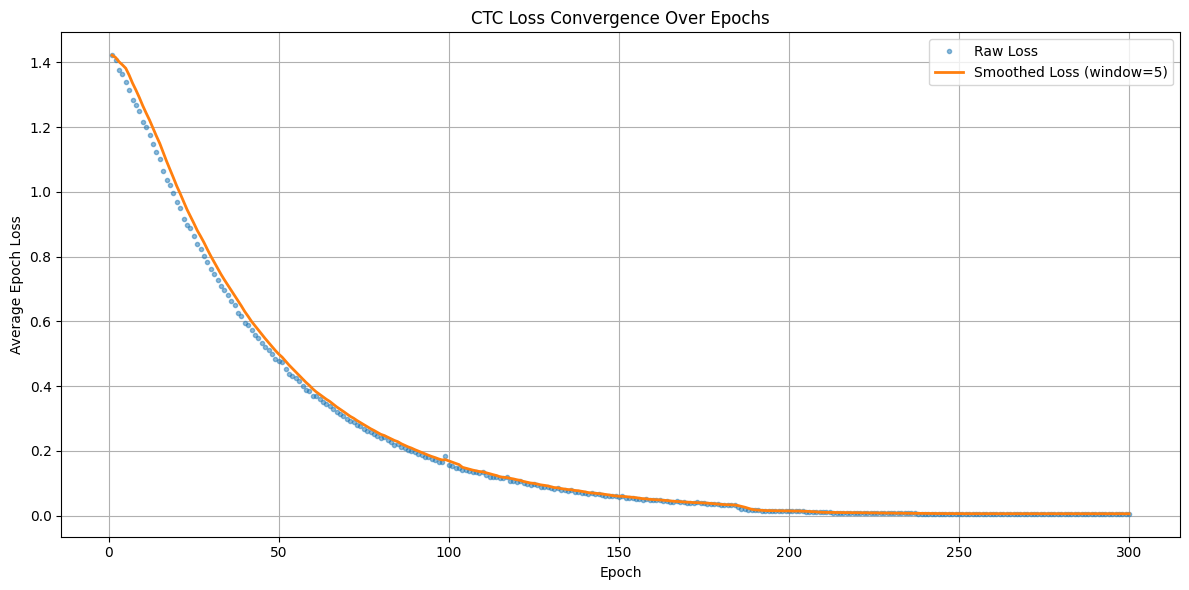

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV with loss values
MODEL_DIR = CHECKPOINTS_DIR / "ctc_model"
loss_df = pd.read_csv(MODEL_DIR / 'Epoch_Loss.csv')

# Filter only average loss rows
avg_loss_df = loss_df[loss_df['Batch'] == 'Average'].copy()
avg_loss_df['Epoch'] = avg_loss_df['Epoch'].astype(int)

# Smooth the curve using a rolling average
avg_loss_df['Smoothed_Loss'] = avg_loss_df['Loss'].rolling(window=5, min_periods=1).mean()

# Plot
plt.figure(figsize=(12, 6))
plt.plot(avg_loss_df['Epoch'], avg_loss_df['Loss'], 'o', markersize=3, alpha=0.5, label='Raw Loss')
plt.plot(avg_loss_df['Epoch'], avg_loss_df['Smoothed_Loss'], '-', linewidth=2, label='Smoothed Loss (window=5)')
plt.title("CTC Loss Convergence Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Average Epoch Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(OUT_DIR / "ctc_plots/ctc_loss_convergence.png")
plt.show()


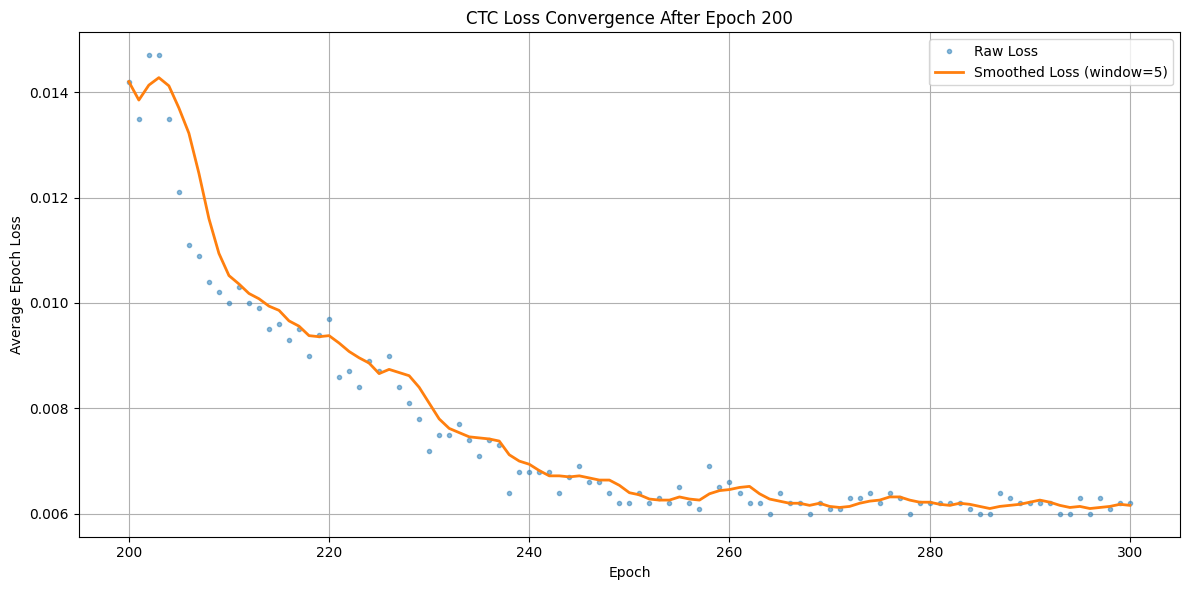

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV with loss values
MODEL_DIR = CHECKPOINTS_DIR / "ctc_model"
loss_df = pd.read_csv(MODEL_DIR / 'Epoch_Loss.csv')
#filter only average loss rows
avg_loss_df = loss_df[loss_df['Batch'] == 'Average'].copy()
avg_loss_df['Epoch'] = avg_loss_df['Epoch'].astype(int)

# Filter for epochs 200 and above
post200_df = avg_loss_df[avg_loss_df['Epoch'] >= 200].copy()
post200_df['Smoothed_Loss'] = post200_df['Loss'].rolling(window=5, min_periods=1).mean()

# Plot
plt.figure(figsize=(12, 6))
plt.plot(post200_df['Epoch'], post200_df['Loss'], 'o', markersize=3, alpha=0.5, label='Raw Loss')
plt.plot(post200_df['Epoch'], post200_df['Smoothed_Loss'], '-', linewidth=2, label='Smoothed Loss (window=5)')
plt.title("CTC Loss Convergence After Epoch 200")
plt.xlabel("Epoch")
plt.ylabel("Average Epoch Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(OUT_DIR / "ctc_plots/ctc_loss_convergence_post200.png")
plt.show()


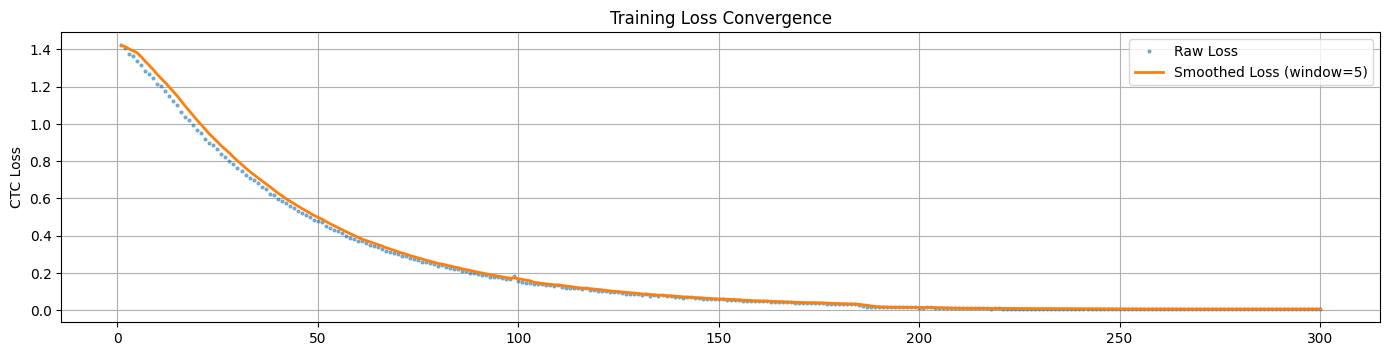

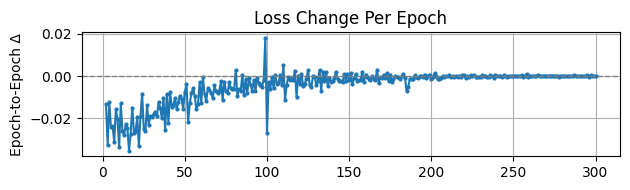

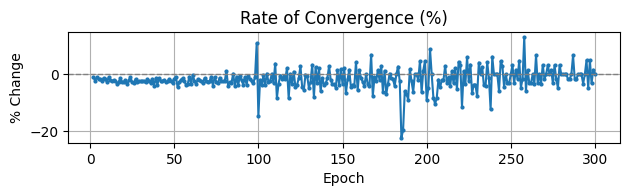

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load the CSV with loss values
MODEL_DIR = CHECKPOINTS_DIR / "ctc_model"
loss_df = pd.read_csv(MODEL_DIR / 'Epoch_Loss.csv')
# clean loss data
avg_loss_df = loss_df[loss_df['Batch'] == 'Average'].copy()
avg_loss_df['Epoch'] = avg_loss_df['Epoch'].astype(int)
avg_loss_df['Loss'] = avg_loss_df['Loss'].astype(float)

# Rolling average (smoothed loss)
avg_loss_df['Smoothed_Loss'] = avg_loss_df['Loss'].rolling(window=5, min_periods=1).mean()

# First-order difference (epoch-to-epoch change)
avg_loss_df['Delta_Loss'] = avg_loss_df['Loss'].diff()

# Rate of convergence (percent change)
avg_loss_df['Rate_of_Change_%'] = avg_loss_df['Loss'].pct_change() * 100

# Plot all metrics
plt.figure(figsize=(14, 10))

# Raw + Smoothed Loss
plt.subplot(3, 1, 1)
plt.plot(avg_loss_df['Epoch'], avg_loss_df['Loss'], 'o', markersize=2, alpha=0.5, label='Raw Loss')
plt.plot(avg_loss_df['Epoch'], avg_loss_df['Smoothed_Loss'], '-', linewidth=2, label='Smoothed Loss (window=5)')
plt.title("Training Loss Convergence")
plt.ylabel("CTC Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(OUT_DIR / "ctc_plots/ctc_loss_convergence.png")
plt.show()

# Loss difference
plt.subplot(3, 1, 2)
plt.plot(avg_loss_df['Epoch'], avg_loss_df['Delta_Loss'], '-o', markersize=2, label='Loss Δ')
plt.axhline(0, color='gray', linestyle='--', linewidth=1)
plt.ylabel("Epoch-to-Epoch Δ")
plt.title("Loss Change Per Epoch")
plt.grid(True)
plt.tight_layout()
plt.savefig(OUT_DIR / "ctc_plots/ctc_loss_delta.png")
plt.show()

# Rate of change
plt.subplot(3, 1, 3)
plt.plot(avg_loss_df['Epoch'], avg_loss_df['Rate_of_Change_%'], '-o', markersize=2, label='Rate of Change (%)')
plt.axhline(0, color='gray', linestyle='--', linewidth=1)
plt.xlabel("Epoch")
plt.ylabel("% Change")
plt.title("Rate of Convergence (%)")
plt.grid(True)
plt.tight_layout()
plt.savefig(OUT_DIR / "ctc_plots/ctc_loss_rate_of_change.png")
plt.show()


# Evaluate

## Re-instantiate the model and load trained weights

In [ ]:
# Load vocab
import json
import torch

# Path to vocab JSON
VOCAB_PATH = DATA_PROCESSED / "vocab" / "char2idx_vocals.json"
# Load vocab
with open(VOCAB_PATH, "r") as f:
    char2idx = json.load(f)

idx2char = {int(i): c for c, i in char2idx.items()}
vocab_size = len(char2idx)

# Rebuild model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = EnhancedCNNBiLSTMCTC(vocab_size).to(device)

# Load weights from checkpoint
model.load_state_dict(torch.load(CHECKPOINTS_DIR / "ctc_model/ctc_model_epoch_300.pt"))
model.eval()


## Evaluate the model on a few samples using greedy decoding


In [ ]:
import torch

model.eval()
with torch.no_grad():
    for i in range(16):
        features, labels = train_dataset[i]
        input_tensor = features.unsqueeze(0).unsqueeze(0).to(device)  # [1, 1, 80, T]
        logits = model(input_tensor)
        log_probs = nn.functional.log_softmax(logits, dim=-1)
        pred = log_probs.argmax(dim=-1).squeeze(0).cpu().tolist()

        # Collapse repeats and remove blanks (CTC decoding)
        prev = -1
        decoded = []
        for p in pred:
            if p != prev and p != 0:
                decoded.append(p)
            prev = p

        decoded_text = ''.join([idx2char[i] for i in decoded])
        true_text = ''.join([idx2char[i] for i in labels.tolist()])

        print(f"🔊 PRED: {decoded_text}\n✅ TRUE: {true_text}\n" + "-"*50)


🔊 PRED: i think you're right i don cre got inhidst thor
✅ TRUE: i think you're right i do
--------------------------------------------------
🔊 PRED: only feel us or youses l lo t yeei ie liou ee 
✅ TRUE: only feel us or you
--------------------------------------------------
🔊 PRED: i know the reasons why boaho t
✅ TRUE: i know the reasons why
--------------------------------------------------
🔊 PRED: you crave more ero s 
✅ TRUE: you crave more
--------------------------------------------------
🔊 PRED: harder than one younsed  lo
✅ TRUE: harder than one
--------------------------------------------------
🔊 PRED: you come up with none little did i think koke wande fre ht sdonee
✅ TRUE: you come up with none little did i think
--------------------------------------------------
🔊 PRED: night owl red night promise ra iosea sone 
✅ TRUE: night owl red night promise
--------------------------------------------------
🔊 PRED: slashes of love i ih a o
✅ TRUE: slashes of love
--------------------

# TEST - data prep

## Extract Audio Features (Mel Spectrograms) From vocal-only stem
convert each vocal stem audio chunk into a log-Mel spectrogram.

In [ ]:
import os
import librosa
import numpy as np
import pandas as pd
from tqdm import tqdm
import torch

# Parameters
SR = 16000  # Sampling rate
N_MELS = 80
HOP_LENGTH = 320
WIN_LENGTH = 1024

# Paths (test data)
CHUNKS_DIR_TEST   = DATA_PROCESSED / "test_chunks" / "vocals"
CSV_PATH_TEST     = DATA_PROCESSED / "test_segments_chunked.csv"
FEATURES_DIR_TEST = DATA_PROCESSED / "features_vocals" / "test"

# Load segment metadata
df = pd.read_csv(CSV_PATH_TEST)
df = df[df['has_lyrics'] == True].reset_index(drop=True)  # keep only vocal chunks with actual lyrics and resets the index

# Create output folder
os.makedirs(FEATURES_DIR_TEST, exist_ok=True)

# Process each chunk
for idx, row in tqdm(df.iterrows(), total=len(df)):
    audio_path = row['chunk_path']
    try:
        # Load audio
        y, _ = librosa.load(audio_path, sr=SR, mono=True)

        # Compute log-mel spectrogram
        mel = librosa.feature.melspectrogram(y=y, sr=SR, n_fft=WIN_LENGTH,
                                             hop_length=HOP_LENGTH,
                                             n_mels=N_MELS)
        log_mel = librosa.power_to_db(mel, ref=np.max)

        # Save as tensor
        tensor = torch.tensor(log_mel).float()
        out_path = os.path.join(FEATURES_DIR_TEST, f"{idx}.pt")
        torch.save(tensor, out_path)
    except Exception as e:
        print(f"Error processing {audio_path}: {e}")


## Prepare Text Labels (Character-Level)
tokenize lyrics into characters and save them aligned to the audio features.

In [ ]:
import os
import json
import torch
import pandas as pd
from tqdm import tqdm

# Paths
CHUNKS_DIR_TEST   = DATA_PROCESSED / "test_chunks" / "vocals"
CSV_PATH_TEST     = DATA_PROCESSED / "test_segments_chunked.csv"
LABELS_DIR_TEST   = DATA_PROCESSED / "labels_vocals" / "test"
VOCAB_PATH = DATA_PROCESSED / "vocab" / "char2idx_vocals.json"

# Load lyric segment metadata
df = pd.read_csv(CSV_PATH_TEST)
df = df[df['has_lyrics'] == True].reset_index(drop=True)  # keep only vocal chunks with actual lyrics, and resets the index

# Load vocab
with open(VOCAB_PATH, "r") as f:
    char2idx = json.load(f)

# Create output directory
os.makedirs(LABELS_DIR_TEST, exist_ok=True)

# Generate and save label tensors
for idx, row in tqdm(df.iterrows(), total=len(df)):
    lyric = row['Lyric'].lower().strip() if row['has_lyrics'] else ''
    label_tensor = torch.tensor([char2idx[c] for c in lyric if c in char2idx], dtype=torch.long)
    torch.save(label_tensor, os.path.join(LABELS_DIR_TEST, f'{idx}.pt'))


## Save labels to csv

In [ ]:
import pandas as pd

# Input and output CSVs
CSV_PATH_TEST_IN  = DATA_PROCESSED / "test_segments_chunked.csv"
CSV_PATH_TEST_OUT = DATA_PROCESSED / "test_segments_vocals.csv"

# Load original test CSV
df = pd.read_csv(CSV_PATH_TEST_IN)

# Replace path prefix so chunk_path points to processed test chunks
df["chunk_path"] = df["chunk_path"].apply(
    lambda p: p.replace(
        "audio_chunks/",   # original prefix inside the CSV
        str((DATA_PROCESSED / "test_chunks" / "vocals") / "")  # new test chunks dir
    )
)

# Save updated CSV
df.to_csv(CSV_PATH_TEST_OUT, index=False)
print(f"✅ Vocal test CSV saved to: {CSV_PATH_TEST_OUT}")


transforms the file names in the CSV to match the actual filenames on disk

In [ ]:
import re
import pandas as pd

# Load the CSV with vocal paths
csv_path = DATA_PROCESSED / "test_segments_vocals.csv"
df = pd.read_csv(csv_path)

# Function to fix the filename format
def fix_timestamps(path):
    # Extract filename
    filename = path.split("/")[-1]
    # Regex: match _xx.xx_yy.yy.wav and convert to _xx_yy.wav
    fixed_filename = re.sub(r'_(\d+)\.(\d+)_([\d]+)\.(\d+)\.wav$',
                            lambda m: f"_{int(m.group(1))}_{int(m.group(3))}.wav",
                            filename)
    # Replace in path
    return path.replace(filename, fixed_filename)

# Apply to chunk_path
df["chunk_path"] = df["chunk_path"].apply(fix_timestamps)

# Save fixed CSV (optional)
df.to_csv(csv_path.replace(".csv", "_fixed.csv"), index=False)
print("✅ Timestamp formatting fixed.")


✅ Timestamp formatting fixed.


In [ ]:
for path in df["chunk_path"].head():
    print(path)


/content/drive/MyDrive/DS_course/Deep_Learning/Final Project/musdb18/test_chunks/vocals/AM Contra - Heart Peripheral_0_10.wav
/content/drive/MyDrive/DS_course/Deep_Learning/Final Project/musdb18/test_chunks/vocals/AM Contra - Heart Peripheral_10_16.wav
/content/drive/MyDrive/DS_course/Deep_Learning/Final Project/musdb18/test_chunks/vocals/AM Contra - Heart Peripheral_16_21.wav
/content/drive/MyDrive/DS_course/Deep_Learning/Final Project/musdb18/test_chunks/vocals/AM Contra - Heart Peripheral_23_30.wav
/content/drive/MyDrive/DS_course/Deep_Learning/Final Project/musdb18/test_chunks/vocals/AM Contra - Heart Peripheral_30_38.wav


## Sanity check on feature and label tensors

Load and inspect a sample feature and its corresponding label to confirm correct formatting, shape, and character mapping.


In [ ]:
import torch
import json

# Sample index to inspect
sample_idx = 420

# Load feature
feature_path = FEATURES_DIR_TEST / f"{sample_idx}.pt"
feature = torch.load(feature_path)
print("Feature shape:", feature.shape)
print("Feature dtype:", feature.dtype)
print("Feature stats — min:", feature.min().item(), "max:", feature.max().item())

# Load label
label_path = (DATA_PROCESSED / "labels_vocals" / "test" / f"{sample_idx}.pt")
label = torch.load(label_path)
print("Label indices:", label.tolist())

# Load vocab
VOCAB_PATH = DATA_PROCESSED / "vocab" / "char2idx_vocals.json"
with open(VOCAB_PATH, "r") as f:
    char2idx = json.load(f)

# Reverse mapping: index → character
idx2char = {int(i): c for c, i in char2idx.items()}

# Decode label
decoded = "".join(idx2char[i] for i in label.tolist())
print("Decoded lyric:", decoded)


Feature shape: torch.Size([80, 451])
Feature dtype: torch.float32
Feature stats — min: -71.24998474121094 max: 0.0
Label indices: [17, 25, 16, 1, 15, 27, 1, 17, 25, 16, 1, 5, 3, 23, 21, 7, 1, 3, 14, 14, 1, 22, 10, 7, 15, 1, 22, 10, 11, 16, 9, 21, 1, 27, 17, 23, 1, 6, 11, 6, 16, 2, 22, 1, 6, 17, 16, 7, 1, 22, 17, 1, 15, 7, 1, 27, 17, 23, 1, 6, 17, 16, 7, 1, 10, 3, 24, 7, 1, 17, 16, 14, 27, 1, 15, 3, 6, 7, 1, 15, 7, 1, 21, 22, 20, 17, 16, 9, 1, 15, 7, 1, 21, 22, 20, 17, 16, 9, 1, 22, 10, 11, 21, 1, 14, 11, 8, 7, 1, 22, 10, 7, 27, 1, 9, 7, 22, 1, 12, 23, 21, 22, 1, 17, 16, 7, 1, 8, 20, 17, 15, 1, 15, 7, 1, 12, 23, 21, 22, 1, 17, 16, 7, 1, 21, 17, 1, 11, 1, 15, 3, 1, 14, 11, 24, 7, 1, 11, 22, 1, 14, 17, 16, 9]
Decoded lyric: own my own cause all them things you didn't done to me you done have only made me strong me strong this life they get just one from me just one so i ma live it long


# Test Evaluation - CTC Model on Vocal-Only

In [ ]:
!pip install jiwer

In [ ]:
# ================================================
# 🔧 SETUP
# ================================================
import os
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import json
from jiwer import wer, cer
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Paths
FEATURES_DIR_TEST = DATA_PROCESSED / "features_vocals" / "test"
LABELS_DIR_TEST   = DATA_PROCESSED / "labels_vocals"  / "test"
VOCAB_PATH        = DATA_PROCESSED / "vocab" / "char2idx_vocals.json"
MODEL_PATH        = CHECKPOINTS_DIR / "ctc_model" / "ctc_model_epoch_300.pt"

# ================================================
#  LOAD VOCAB
# ================================================
with open(VOCAB_PATH, 'r') as f:
    char2idx = json.load(f)
idx2char = {int(v): k for k, v in char2idx.items()}
blank_idx = 0

# ================================================
#  DATASET & COLLATE
# ================================================
class TestCTCDataset(Dataset):
    def __init__(self, features_dir, labels_dir):
        self.features_dir = features_dir
        self.labels_dir = labels_dir
        self.indices = sorted([int(f.split(".")[0]) for f in os.listdir(features_dir)])

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        i = self.indices[idx]
        x = torch.load(os.path.join(self.features_dir, f"{i}.pt"))  # [80, T]
        y = torch.load(os.path.join(self.labels_dir, f"{i}.pt"))    # [L]
        return x, y

def collate_fn(batch):
    xs, ys = zip(*batch)
    x_lengths = [x.shape[1] for x in xs]
    y_lengths = [len(y) for y in ys]

    x_padded = torch.nn.utils.rnn.pad_sequence([x.T for x in xs], batch_first=True).permute(0, 2, 1)  # [B, 80, T_max]
    y_padded = torch.nn.utils.rnn.pad_sequence(ys, batch_first=True)  # [B, L_max]

    return x_padded.unsqueeze(1), y_padded, torch.tensor(x_lengths), torch.tensor(y_lengths)

test_loader = DataLoader(TestCTCDataset(FEATURES_DIR_TEST, LABELS_DIR_TEST), batch_size=1, shuffle=False, collate_fn=collate_fn)

# ================================================
#  LOAD TRAINED MODEL
# ================================================
# Define  model class exactly as used during training
class EnhancedCNNBiLSTMCTC(nn.Module):
    def __init__(self, vocab_size):
        super(EnhancedCNNBiLSTMCTC, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.MaxPool2d((2, 2)),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.MaxPool2d((2, 2)),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(0.1),
        )

        self.rnn = nn.LSTM(input_size=2560,
                           hidden_size=256,
                           num_layers=2,
                           batch_first=True,
                           bidirectional=True,
                           dropout=0.2)

        self.classifier = nn.Linear(512, vocab_size)

        for name, param in self.rnn.named_parameters():
            if 'weight' in name:
                nn.init.xavier_uniform_(param)

    def forward(self, x):
        out = self.cnn(x)  # [B, C, F, T]
        B, C, F, T = out.size()
        out = out.permute(0, 3, 1, 2).contiguous()  # [B, T, C, F]
        out = out.view(B, T, C * F)  # [B, T, C*F]
        rnn_out, _ = self.rnn(out)
        logits = self.classifier(rnn_out)
        return logits

model = EnhancedCNNBiLSTMCTC(vocab_size=len(char2idx)).to(device)
model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
model.eval()


# ================================================
#  DECODE FUNCTION
# ================================================
def greedy_decode(logits):
    preds = torch.argmax(logits, dim=-1).squeeze(0).tolist()
    out = []
    prev = -1
    for p in preds:
        if p != prev and p != blank_idx and p in idx2char:
            out.append(idx2char[p])
        prev = p
    return ''.join(out)

# ================================================
#  EVALUATION LOOP
# ================================================
all_preds, all_refs = [], []

with torch.no_grad():
    for batch in tqdm(test_loader):
        x, y, x_lens, y_lens = [b.to(device) for b in batch]
        logits = model(x)  # [B, T, V]
        log_probs = torch.nn.functional.log_softmax(logits, dim=-1)

        pred_text = greedy_decode(log_probs[0].cpu())
        ref_text = ''.join([idx2char[i.item()] for i in y[0] if i.item() in idx2char])

        all_preds.append(pred_text)
        all_refs.append(ref_text)

# Normalize for WER/CER
import re
def normalize(text):
    text = text.lower().strip()
    return re.sub(r"[^\w\s]", "", text)

norm_preds = [normalize(t) for t in all_preds]
norm_refs = [normalize(t) for t in all_refs]

# Compute metrics
print("🔤 Word Error Rate (WER):", wer(norm_refs, norm_preds))
print("🔠 Character Error Rate (CER):", cer(norm_refs, norm_preds))

# Optionally: Show a few predictions
for i in range(5):
    print(f"\nExample {i+1}")
    print("GT :", norm_refs[i])
    print("PRD:", norm_preds[i])


100%|██████████| 1065/1065 [14:14<00:00,  1.25it/s]🔤 Word Error Rate (WER): 1.374896703700303
🔠 Character Error Rate (CER): 0.9367507480135534

Example 1
GT : take on big bite of life to go
PRD: so io me ao eor woe or o o ons toe t

Example 2
GT : take an apple please from the front row
PRD: yoa a o coe oe tor to seer tusassnee

Example 3
GT : oh soon enough never good enough
PRD: sos ae toer fome o hs hero to on oe ton  chen nely mco mho

Example 4
GT : inch by inch come on connect the dots
PRD: dont te oere or mo to  oo ta

Example 5
GT : yeah keep keep keep me in your line of sight squeeze squeeze
PRD: per ao toe ou fot h tho soe doadane ai thome aon o wont tin ou


# Failure analysis
> High training accuracy with poor test WER/CER indicates strong overfitting due to limited data + capacity mismatch